In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Proximity data

In [2]:
schema = 'prox_analysis'
folder = 'proximityanalysis_v2_23_mzaageb_hex'
city = 'Guadalajara'
res = 9

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' and \"res\" = \'{res}\' "

hex_prox = aup.gdf_from_query(query)
print(hex_prox.shape)
hex_prox.head(2)

(6408, 69)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,pobmas,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city
0,89498c9457bffff,9,"POLYGON ((-103.32578 20.6826, -103.32456 20.68...",21.848540,5.473723,7.704430,21.848540,22.125134,4.683096,6.588649,...,201.46724,22.052925,24.913023,24.610813,43.04035,200.00954,79.25311,43.609848,31.847961,Guadalajara
1,89498c9450bffff,9,"POLYGON ((-103.32944 20.67775, -103.32822 20.6...",14.138125,5.248436,4.213016,14.138125,22.240913,5.500798,4.193477,...,815.30194,101.968071,101.293890,119.649084,206.16394,882.50156,280.52070,87.985855,136.968658,Guadalajara


In [3]:
hex_prox.columns

Index(['hex_id', 'res', 'geometry', 'max_escuelas', 'max_preescolar',
       'max_primaria', 'max_secundaria', 'max_servicios comunitarios',
       'max_salud', 'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_h

#### View specific amenity

In [4]:
hex_prox[['idx_sum']].head(2)

,idx_sum
0,12.877841
1,13.220001


<Axes: >

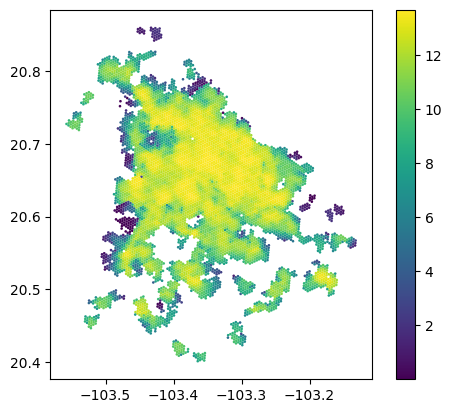

In [5]:
hex_prox.plot('idx_sum', legend=True)

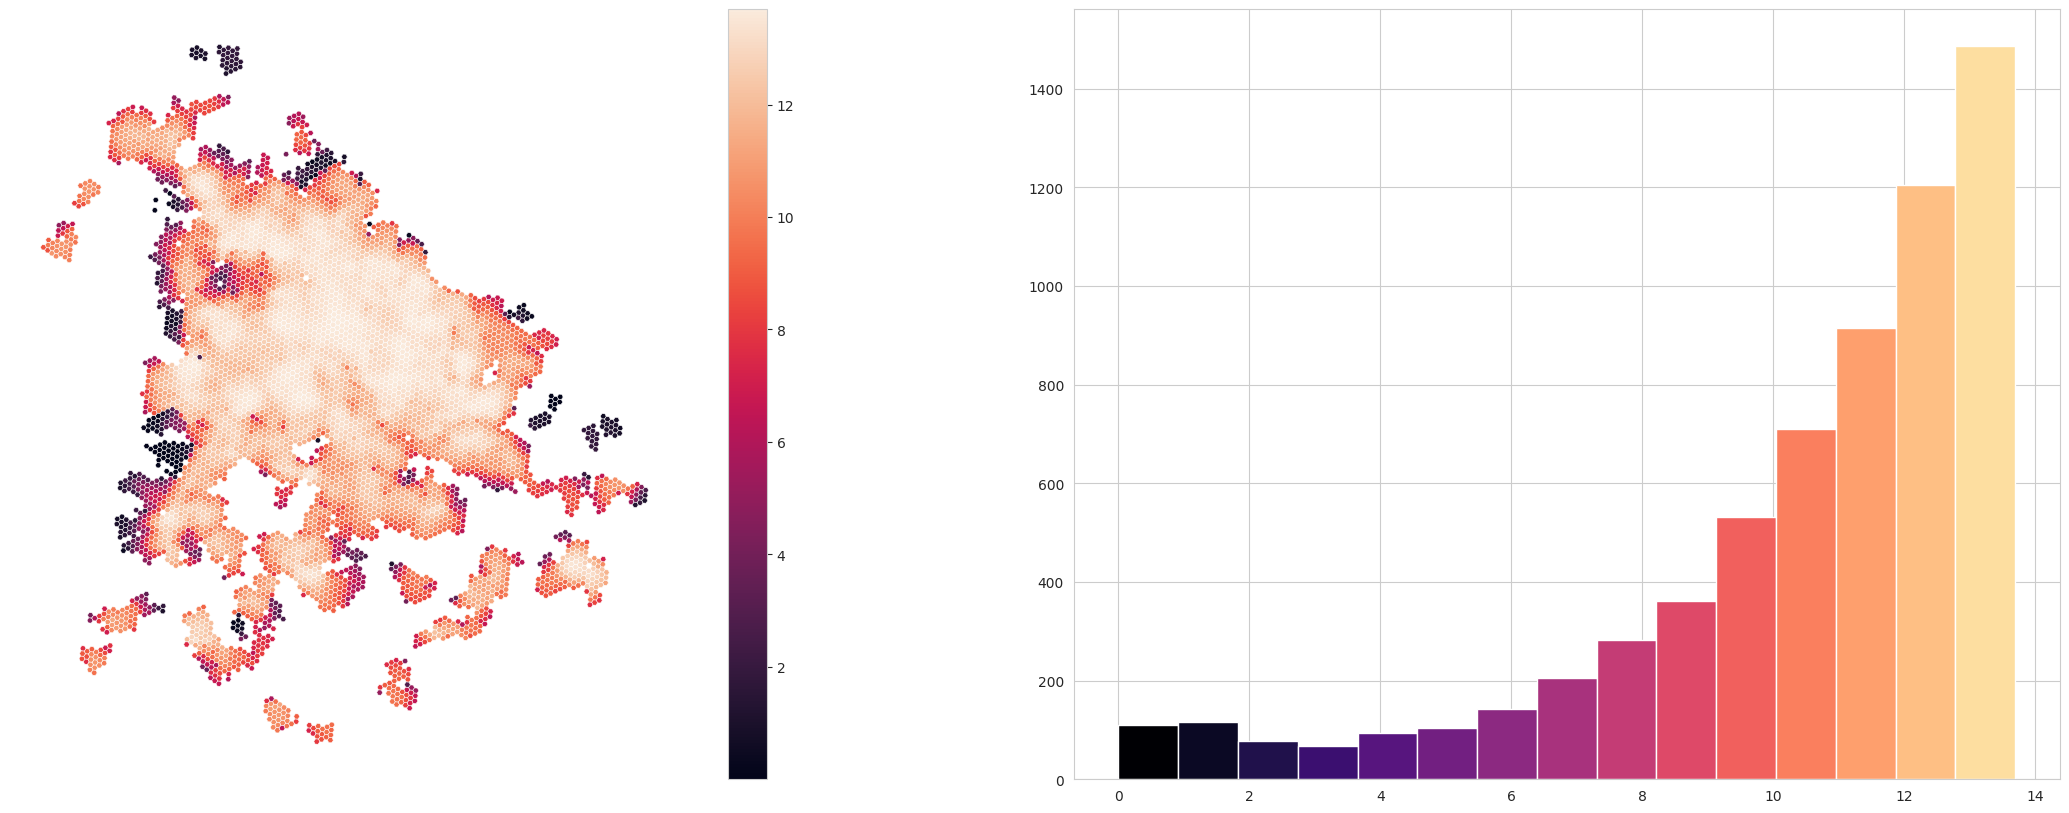

In [6]:
import seaborn as sns 

column_analysis = 'idx_sum'

sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(28,10))
hex_prox.plot(column=column_analysis, linewidth=0.4,
                       legend=True, ax=ax[0]) 
ax[0].set_axis_off()

hex_prox.sort_values(column_analysis,inplace=True)
hex_prox.reset_index(drop=True, inplace=True)
n, bins, patches = ax[1].hist(hex_prox[column_analysis],
                             15, color='green')

cm = plt.cm.magma
 
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(n))) # notice the i/25

## Filter data

In [7]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')

In [14]:
if hex_prox.crs!=aoi_gdf.crs:
    hex_prox = hex_prox.to_crs(aoi_gdf.crs)
    print(hex_prox.crs)

EPSG:32613


In [18]:
hex_clip_id = hex_prox.clip(aoi_gdf).hex_id.unique()
hex_prox_aoi = hex_prox.loc[hex_prox.hex_id.isin(hex_clip_id)].copy()
print(hex_prox_aoi.shape)
hex_prox_aoi.head(2)

(106, 69)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,pobmas,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city
572,8949aa2c4b7ffff,9,"POLYGON ((672958.898 2266954.601, 673084.119 2...",45.406085,39.537726,37.760830,45.406085,80.770976,28.774856,72.361528,...,142.665340,51.207965,45.363552,27.708400,28.363370,135.506361,5.748339,6.021350,23.754549,Guadalajara
622,8949aa2c4a3ffff,9,"POLYGON ((673302.966 2267117.834, 673428.188 2...",43.842222,39.549871,36.225709,43.842222,78.811321,23.852020,70.455215,...,0.000142,0.000043,0.000014,0.000036,0.000085,0.000122,0.000006,0.000004,0.000025,Guadalajara


## Save data

In [19]:
hex_prox_aoi.to_file('../../../data/processed/viviendas_tlajo/hex_proximity_viviendas_tlajo.geojson')